In [1]:
# tensorflow imports
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, MaxPooling2D, Dense, Input, Activation, AveragePooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAvgPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, GlorotNormal
from tensorflow.keras.utils import plot_model
from scipy.ndimage.interpolation import rotate
from scipy import signal
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import CSVLogger

from tqdm import tqdm
import numpy as np
import os
import pywt
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')


In [3]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# a filter
filter1 = np.array([[[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]],
                    [[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]],
                    [[0,0,0], [0,0,0], [0,0,0], [-1,-2,-3], [1,2,3]],
                    [[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]],
                    [[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]]])
filtera1 = rotate(filter1, angle=90)
filtera2 = rotate(filter1, angle=180)
filtera3 = rotate(filter1, angle=270)


# d filter
filter2 = np.array([[[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]],
                    [[0,0,0], [-1,-2,-3],[2,4,6],[-1,-2,-3], [0,0,0]],
                    [[0,0,0], [2,4,6],[-4,-8,-12], [2,4,6],[0,0,0]],
                    [[0,0,0], [-1,-2,-3], [2,4,6], [-1,-2,-3], [0,0,0]],
                    [[0,0,0],[0,0,0],[0,0,0], [0,0,0], [0,0,0]]])


# b filter
fitler3 = np.array([[[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]],
                    [[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]],
                    [[0,0,0], [1,2,3], [-2,-4,-6], [1,2,3], [0,0,0]],
                    [[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]],
                    [[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]]])
filterb1 =  signal.convolve(filter2, filter2, mode='same')
filterb2 =  signal.convolve(filter2, filter2, mode='same')
filterb3 =  signal.convolve(filter2, filter2, mode='same')

# c filter
filter4 = np.array([[[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]], [[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]], [
    [0,0,0], [1,2,3],[-3,-6,-9],[3,6,9],[-1,-2,-3]], [[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]],
                    [[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]]])

#this is not filter
filter4RDT = np.array([[[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]],
                       [[0,0,0], [0,0,0], [1,2,3], [0,0,0], [0,0,0]],
                       [[0,0,0], [0,0,0], [-3,-6,-9], [0,0,0], [0,0,0]],
                       [[0,0,0], [0,0,0], [3,6,9], [0,0,0], [0,0,0]],
                       [[0,0,0], [0,0,0], [-1,-2,-3], [0,0,0], [0,0,0]]])


filterc1 =  signal.convolve(filter4, filter4, mode='same')
filterc2 =  signal.convolve(filter4.T, filter4.T, mode='same').reshape(5,5,3)
filterc3 =  signal.convolve(filter4RDT, filter4RDT, mode='same').reshape(5,5,3)

#e filter
filter5 = np.array([[[-1,-2,-3], [2,4,6], [-2,-4,-6], [2,4,6], [-1,-2,-3]],
                    [[2,4,6], [-6,-12,-18], [-8,-16,-24], [-6,-12,-18], [2,4,6]],
                   [[-2,-4,-6], [8,16,24], [-12,-24,-36], [8,16,24], [2,4,6]],
                    [[2,4,6], [-6,-12,-18], [8,16,24], [-6,-12,-18], [2,4,6]],
                    [[-1,-2,-3], [2,4,6], [-2,-4,-6], [2,4,6], [-1,-2,-3]]])

filter_list = [filter1.tolist(), filtera1.tolist(), filtera2.tolist(), filtera3.tolist(), filter2.tolist(),\
               fitler3.tolist(), filterb1.tolist(), filterb2.tolist(), filterb3.tolist(),\
               filter4.tolist(), filterc1.tolist(), filterc2.tolist(), filterc3.tolist(), filter5.tolist()]

In [5]:
np.array([filter1,filtera1, filtera2, filtera3, filter2, fitler3, filterb1, filterb2, filterb3, filter4, filterc1]).shape

(11, 5, 5, 3)

In [6]:
%load_ext tensorboard

In [7]:
Inp = Input(shape = (64, 64, 3))
x = Conv2D(14, (5,5), padding = 'same', name = 'conv2d_1')(Inp)
x = Conv2D(16, (5,5), kernel_initializer= tf.keras.initializers.glorot_normal(seed=26), name = 'conv2d_2')(x)
x = ZeroPadding2D((1,1))(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (5,5), padding = 'same',kernel_initializer= tf.keras.initializers.glorot_normal(seed=26), name = 'conv2d_3')(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), padding = 'same',kernel_initializer= tf.keras.initializers.glorot_normal(seed=26), name = 'conv2d_4')(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (1,1), padding = 'same',kernel_initializer= tf.keras.initializers.glorot_normal(seed=26), name = 'conv2d_5')(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(256, (1,1), padding = 'same',kernel_initializer= tf.keras.initializers.glorot_normal(seed=26), name = 'conv2d_6')(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = AveragePooling2D((2,2))(x)
x = Flatten()(x)
out = Dense(1, activation = 'sigmoid',kernel_initializer= tf.keras.initializers.glorot_normal(seed=26), name = 'ouput')(x)

model = Model(inputs = [Inp], outputs = [out])
model.summary()

#plot_model(model, show_shapes =True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 14)        1064      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        5616      
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 62, 62, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 62, 62, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0     

In [9]:
try:
    os.mkdir('../models/logs')
except Exception as e:
    print(e)

In [10]:
try:
    os.mkdir('../models/weights')
except Exception as e:
    print(e)

In [12]:
try:
    os.mkdir('../models/checkpoints')
except Exception as e:
    print(e)

In [8]:
csv_logger = CSVLogger("../models/weights/tanh_history_log2.csv", append=True)

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
log_dir = r"..\\models\\logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filepath = '../models/checkpoints/model-tanh-try2.h5';
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)

In [10]:
earlyStopping = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [11]:
layer = model.get_layer('conv2d_1')
layer.set_weights([np.array(filter_list).astype(np.float32).reshape(5,5,3,14), np.zeros(14,)])

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255.0,shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1/255.0)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '../input/patches/train/',  # This is the source directory for training images
        target_size=(64, 64),  # All images will be resized to 64x64
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        '../input/patches/validation/',  # This is the source directory for validation images
        target_size=(64, 64),  # All images will be resized to 64x64
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 3751091 images belonging to 2 classes.
Found 537266 images belonging to 2 classes.


In [17]:
train_generator.class_indices

{'fake': 0, 'pristine': 1}

In [18]:
history = model.fit(
      train_generator,  
      epochs=100,
    validation_data = validation_generator,
      verbose=1,
      callbacks=[tensorboard_callback, checkpoint, earlyStopping, csv_logger])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 58611 steps, validate for 8395 steps
Epoch 1/100
58610/58611 [============================>.] - ETA: 0s - loss: 0.4955 - accuracy: 0.7620
Epoch 00001: val_loss improved from inf to 0.47806, saving model to ../models/checkpoints/model-tanh-try2.h5
58611/58611 [==============================] - 5754s 98ms/step - loss: 0.4955 - accuracy: 0.7620 - val_loss: 0.4781 - val_accuracy: 0.7610
Epoch 2/100
58610/58611 [============================>.] - ETA: 0s - loss: 0.4303 - accuracy: 0.8016
Epoch 00002: val_loss improved from 0.47806 to 0.41553, saving model to ../models/checkpoints/model-tanh-try2.h5
58611/58611 [==============================] - 5780s 99ms/step - loss: 0.4303 - accuracy: 0.8016 - val_loss: 0.4155 - val_accuracy: 0.8083
Epoch 3/100
58610/58611 [============================>.] - ETA: 0s - loss: 0.4038 - accuracy: 0.8162
Epoch 00003: val_loss improved from 0.41553 to 0.39746, saving model to ../models/checkpoints/model-

In [21]:
%tensorboard --logdir ../models

Reusing TensorBoard on port 6006 (pid 30260), started 0:45:05 ago. (Use '!kill 30260' to kill it.)

In [22]:
test_datagen = ImageDataGenerator(rescale=1/255.0)
test_generator = test_datagen.flow_from_directory(
        '../input/patches/test/',  # This is the source directory for test images
        target_size=(64, 64),  # All images will be resized to 64x64
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1079666 images belonging to 2 classes.


In [25]:
perf = model.evaluate(test_generator)

  ...
    to  
  ['...']
16870/16870 [==============================] - 701s 42ms/step - loss: 0.3388 - accuracy: 0.8539


In [26]:
perf

[0.338817194007474, 0.8539002]

In [27]:
import os
true_labels_train = []
true_labels_test = []
true_labels_validation = []


In [28]:
for i in os.listdir('../input/data-prep/train/fake/'):
    true_labels_train.append(0)
for i in os.listdir('../input/data-prep/train/pristine/'):
    true_labels_train.append(1)
for j in os.listdir('../input/data-prep/validation/fake/'):
    true_labels_validation.append(0)
for j in os.listdir('../input/data-prep/validation/pristine/'):
    true_labels_validation.append(1)
for j in os.listdir('../input/data-prep/test/fake/'):
    true_labels_test.append(0)
for j in os.listdir('../input/data-prep/test/pristine/'):
    true_labels_test.append(1)



In [29]:
predicted_labels_train = []
predicted_labels_test = []
predicted_labels_validation = []

In [30]:
import cv2

In [38]:
def patch_generation(img_path: str, stride = (8, 8)):
    patches = []
    new_img = cv2.imread(img_path)

    (h, w, c) = new_img.shape
    h_range = h - 64
    w_range = w - 64
    # print(h_range, w_range)
    for i in range(0,h_range, stride[0]):
        for j in range(0, w_range, stride[1]):
            patch = np.zeros((64,64,3))
            for k in range(64):
                row = new_img[(i + k):(i + 1 + k), ( j ) : (j+ 64), :]
                patch[k, :, :] = row

            patch = np.array(patch, dtype='int')
            patches.append(patch)
    return patches

In [57]:
patches = patch_generation('../input/data-prep/train/pristine/000bc3906100ede4b1374cea075adedb.png', stride = (8, 8))

In [58]:
# predictions = []
#for i in patches:
#    tmp =  model.predict_step(i)
#    predictions.append(tmp)
predictions = model.predict(np.array(patches), batch_size=1)

In [122]:
predictions_train = []
true_train = []

In [123]:
def custom_image_gen(folder: str, batch_size: int, label: int):
    print('looking in ', folder)
    samples = os.listdir(folder)
    # samples = data_shuffle(path)
    num_samples = len(samples)
    # while loop so that generators never terminates
    while True:
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            #x and y for this batch
            X = []
            Y = []
            
            for batch_sample in batch_samples:
                fileName = batch_sample
                label = label
                image = cv2.imread(folder + fileName)
                image = np.divide(image , 255.0)
                X.append(image)
                Y.append(label)
            yield np.array(X), Y

In [124]:
imageGenerator = custom_image_gen('../input/patches/train/fake/', 64, 0)
#imageGenerator.next()

In [125]:
fileLength = len(os.listdir('../input/patches/train/fake/'))
for i in tqdm(range(0, fileLength, 64)):
    samples, labels = next(imageGenerator)
    true_train.extend(labels)
    prediction = model.predict_on_batch(samples)
    prediction = np.array(prediction).reshape(prediction.shape[0],).tolist()
    predictions_train.extend(prediction)

  0%|                                                                                        | 0/22543 [00:00<?, ?it/s]

looking in  ../input/patches/train/fake/


100%|████████████████████████████████████████████████████████████████████████████| 22543/22543 [18:19<00:00, 20.51it/s]


In [127]:
imageGenerator = custom_image_gen('../input/patches/train/pristine/', 64, 1)
fileLength = len(os.listdir('../input/patches/train/pristine/'))
for i in tqdm(range(0, fileLength, 64)):
    samples, labels = next(imageGenerator)
    true_train.extend(labels)
    prediction = model.predict_on_batch(samples)
    prediction = np.array(prediction).reshape(prediction.shape[0],).tolist()
    predictions_train.extend(prediction)

  0%|                                                                                        | 0/36069 [00:00<?, ?it/s]

looking in  ../input/patches/train/pristine/


100%|████████████████████████████████████████████████████████████████████████████| 36069/36069 [28:19<00:00, 21.23it/s]


In [128]:
from sklearn.metrics import roc_curve

In [132]:
predictions_inverse = [1-x for x in predictions_train]
true_inverse = [1-x for x in true_train]

In [133]:
fpr, tpr, thresholds = roc_curve(true_inverse, predictions_inverse, pos_label=1)

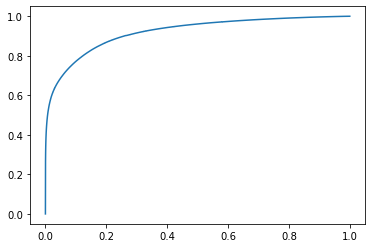

In [134]:
plt.plot(fpr, tpr)
plt.show()

> For example, in a smog prediction system, we may be far more concerned with having low false negatives than low false positives. A false negative would mean not warning about a smog day when in fact it is a high smog day, leading to health issues in the public that are unable to take precautions. A false positive means the public would take precautionary measures when they didn’t need to.

In [135]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(true_inverse, predictions_inverse)

No handles with labels found to put in legend.


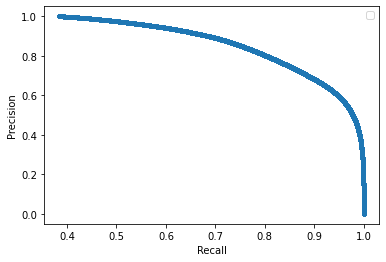

In [138]:
plt.plot(precision, recall, marker='.')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [139]:
def calc_f1_score(precision, recall):
    tmp = (2 * (precision * recall)) / (precision + recall)
    return tmp

In [144]:
f1_scores = []

for precision, recall in zip(precision, recall):
    score = calc_f1_score(precision, recall)
    f1_scores.append(score)

In [149]:
optimal_index = np.argmax(np.array(f1_scores))

In [153]:
threshold = thresholds[optimal_index]

In [155]:
prediction_labels = [1 if x >= threshold else 0 for x in predictions_inverse]

In [156]:
from sklearn.metrics import confusion_matrix

In [162]:
con_matrix_train = confusion_matrix(true_inverse, prediction_labels)

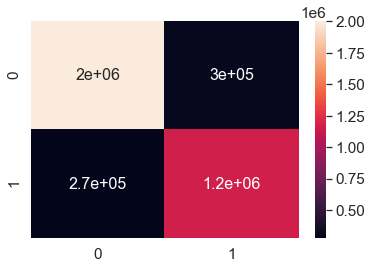

In [163]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = con_matrix_train

df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()